In [12]:
import torch
import argparse
import random
import math
from torch.utils import data
from torchvision import datasets, transforms

from J_Model import PCModel
import J_optim as optim
import J_utils as utils

from PIL import Image
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
from copy import copy
from time import perf_counter
from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd

from stimuli_data import *
from image_net_data import *

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
default_font_size = 18
plt.rcParams.update({'font.size': default_font_size})

In [15]:
# ====================================================================================
#
# Global Parameters and Settings
#
# ====================================================================================
parser = argparse.ArgumentParser(description='Predictive Coding')

# dataset params
parser.add_argument('--batch-size', type=int, default=64,
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000,
                    help='input batch size for testing (default: 1000)')

# optim params
parser.add_argument('--lr', type=float, default=1e-4, help='learning rate')
parser.add_argument('--epoch', type=int, default=9, help='epochs for training') #12

# inference params
parser.add_argument('--infer-lr', type=float, default=0.005, help='Inference learning rate')
parser.add_argument('--infer-iter', type=int, default=500, help='Iteration for inference') #500
parser.add_argument('--test-iter', type=int, default=500, help='Iteration for testing') #2000
parser.add_argument('--test-infer-iter', type=int, default=20000, help='Iteration for testing') #20000
parser.add_argument('--test-lr', type=int, default=0.005, help='Iteration for testing')

# convergence tolerance
parser.add_argument('--train-convergence-norm', type=str, default="L1", help="Norm for measuring convergence")
parser.add_argument('--train-convergence-tolerance', type=float, default=1e-10, help="Tolerance for measuring convergence")
parser.add_argument('--test-convergence-norm', type=str, default="L1", help="Norm for measuring convergence")
parser.add_argument('--test-convergence-tolerance', type=float, default=1e-4, help="Tolerance for measuring convergence")

# experiment params
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
parser.add_argument('--test-every', type=int, default=13, help='Test Cycle regards to Epoch ')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')

# args = parser.parse_args()
args, unknown = parser.parse_known_args()

# Gpu Setting
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Misc. Setting
# torch.manual_seed(args.seed)
torch.manual_seed(random.randint(0,1024))

In [16]:
def derivative(arr, step_size=args.test_lr):
    return np.gradient(arr, step_size, axis=0)

In [17]:
classes = ["n11939491", "n04330267", "n04326547", "n04328186", "n04330267", "n09468604", "n09472597", "n04522168", "n02974003",
           "n03220513", "n03223299", "n03240683", "n03355925", "n03930630", "n03837869", "n03773504", "n03530642", "n02701002", 
           "n02747177", "n02727426", "n02980441"]

In [18]:
population_size = 45
networks = [PCModel(
    nodes=[2, 100, 200, 300, 6800], #[2, 100, 200, 300, 6800]
    mu_dt=args.infer_lr,
    act_fn=utils.Tanh()) for i in range(population_size)]
for model_idx, model in enumerate(networks):
    for i in range(len(model.layers)):
        with open(f'Weights/model_{model_idx}_june_14_params_{i}.pickle', 'rb') as file:
            networks[model_idx].layers[i].weights = pickle.load(file)
model = networks[np.random.randint(0, len(networks))]

In [7]:
test_dl = get_dataloader_features(feature=8, num_translations=0, num_rotations=0, batch_size=8)

In [8]:
test_dl2 = get_dataloader_features(feature=5, num_translations=0, num_rotations=0, batch_size=8)

# Activities

In [9]:
conv_times = []
#print(conv_times)
acc = 0 
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)

    label_preds, times, phase_space = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                     tol=1e-4, norm=args.test_convergence_norm, 
                                                     mu_dt=args.test_lr, norm_errors=False)
    
    for idx in range(len(times)):
        if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
            conv_times.append(times[idx])
        elif False: #testing plotting
            conv_times.append(np.random.random())

    acc += utils.Want_accuracy(label_preds, label_batch)

#print(sorted(conv_times))
print(len(conv_times))

8


In [10]:
conv_times = []
#print(conv_times)
acc = 0 
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl2))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)

    label_preds, times, phase_space2 = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                     tol=1e-4, norm=args.test_convergence_norm, 
                                                     mu_dt=args.test_lr, norm_errors=False)
    
    for idx in range(len(times)):
        if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
            conv_times.append(times[idx])
        elif False: #testing plotting
            conv_times.append(np.random.random())

    acc += utils.Want_accuracy(label_preds, label_batch)

#print(sorted(conv_times))
print(len(conv_times))

8


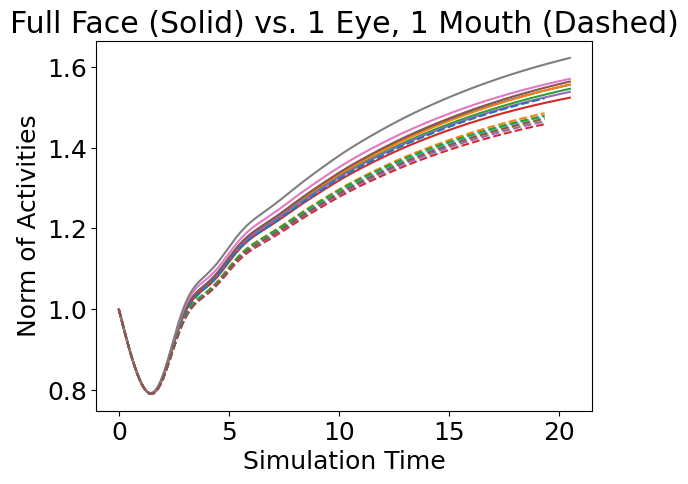

In [11]:
rows, cols = phase_space.shape
rows2, cols2 = phase_space2.shape

plt.figure()

plt.plot([args.test_lr*i for i in range(rows)], phase_space)

"""
plt.xlabel("Simulation Time")
plt.ylabel("Norm of Activities")
plt.title("Full Face")
plt.show()

plt.figure()
"""
plt.plot([args.test_lr*i for i in range(rows2)], phase_space2, ls="--")

plt.xlabel("Simulation Time")
plt.ylabel("Norm of Activities")
#plt.title("1 Eye, 1 Mouth")
plt.title("Full Face (Solid) vs. 1 Eye, 1 Mouth (Dashed)")
plt.show()

# Errors

In [12]:
conv_times = []
#print(conv_times)
acc = 0 
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)

    label_preds, times, phase_space = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                     tol=1e-4, norm=args.test_convergence_norm, 
                                                     mu_dt=args.test_lr, norm_errors=True)
    
    for idx in range(len(times)):
        if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
            conv_times.append(times[idx])
        elif False: #testing plotting
            conv_times.append(np.random.random())

    acc += utils.Want_accuracy(label_preds, label_batch)

#print(sorted(conv_times))
print(len(conv_times))

8


In [13]:
conv_times = []
#print(conv_times)
acc = 0 
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl2))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)

    label_preds, times, phase_space2 = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                     tol=1e-4, norm=args.test_convergence_norm, 
                                                     mu_dt=args.test_lr, norm_errors=True)
    
    for idx in range(len(times)):
        if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
            conv_times.append(times[idx])
        elif False: #testing plotting
            conv_times.append(np.random.random())

    acc += utils.Want_accuracy(label_preds, label_batch)

#print(sorted(conv_times))
print(len(conv_times))

8


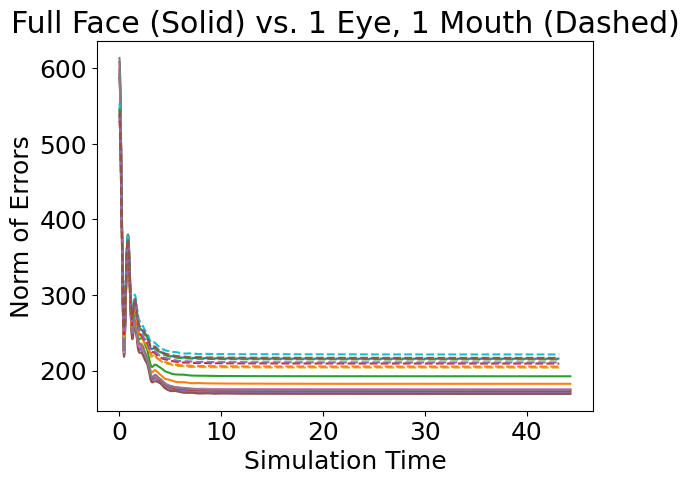

In [14]:
rows, cols = phase_space.shape
rows2, cols2 = phase_space2.shape

plt.figure()

plt.plot([args.test_lr*i for i in range(rows)], phase_space)

"""
plt.xlabel("Simulation Time")
plt.ylabel("Norm of Errors")
plt.title("Full Face")
plt.show()

plt.figure()
"""
plt.plot([args.test_lr*i for i in range(rows2)], phase_space2, ls="--")

plt.xlabel("Simulation Time")
plt.ylabel("Norm of Errors")
#plt.title("1 Eye, 1 Mouth")
plt.title("Full Face (Solid) vs. 1 Eye, 1 Mouth (Dashed)")
plt.show()

# Look at Each Layer

In [15]:
test_dl_single_sample = get_dataloader_features(feature=8, num_translations=0, num_rotations=0, batch_size=1)

In [16]:
phase_spaces = []
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl_single_sample))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)

    for layer_idx in range(len(model.layers)):
        conv_times = []
        label_preds, times, phase_space = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                         tol=1e-4, norm="Activity", 
                                                         mu_dt=args.test_lr, error_dt=args.test_lr, norm_errors=False, activities_index=layer_idx)
        phase_spaces.append(phase_space)
        for idx in range(len(times)):
            if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
                conv_times.append(times[idx])
        print(conv_times)

[2.24]
[2.24]
[2.24]


In [10]:
test_dl_single_sample2 = get_dataloader_features(feature=5, num_translations=0, num_rotations=0, batch_size=1)

In [11]:
phase_spaces2 = []
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl_single_sample2))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)

    for layer_idx in range(len(model.layers)):
        conv_times = []
        label_preds, times, phase_space = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                         tol=1e-4, norm="Activity", 
                                                         mu_dt=args.test_lr, error_dt=args.test_lr, norm_errors=False, activities_index=layer_idx)
        phase_spaces2.append(phase_space)
        for idx in range(len(times)):
            if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
                conv_times.append(times[idx])
        print(conv_times)

[2.48]
[2.48]
[2.48]


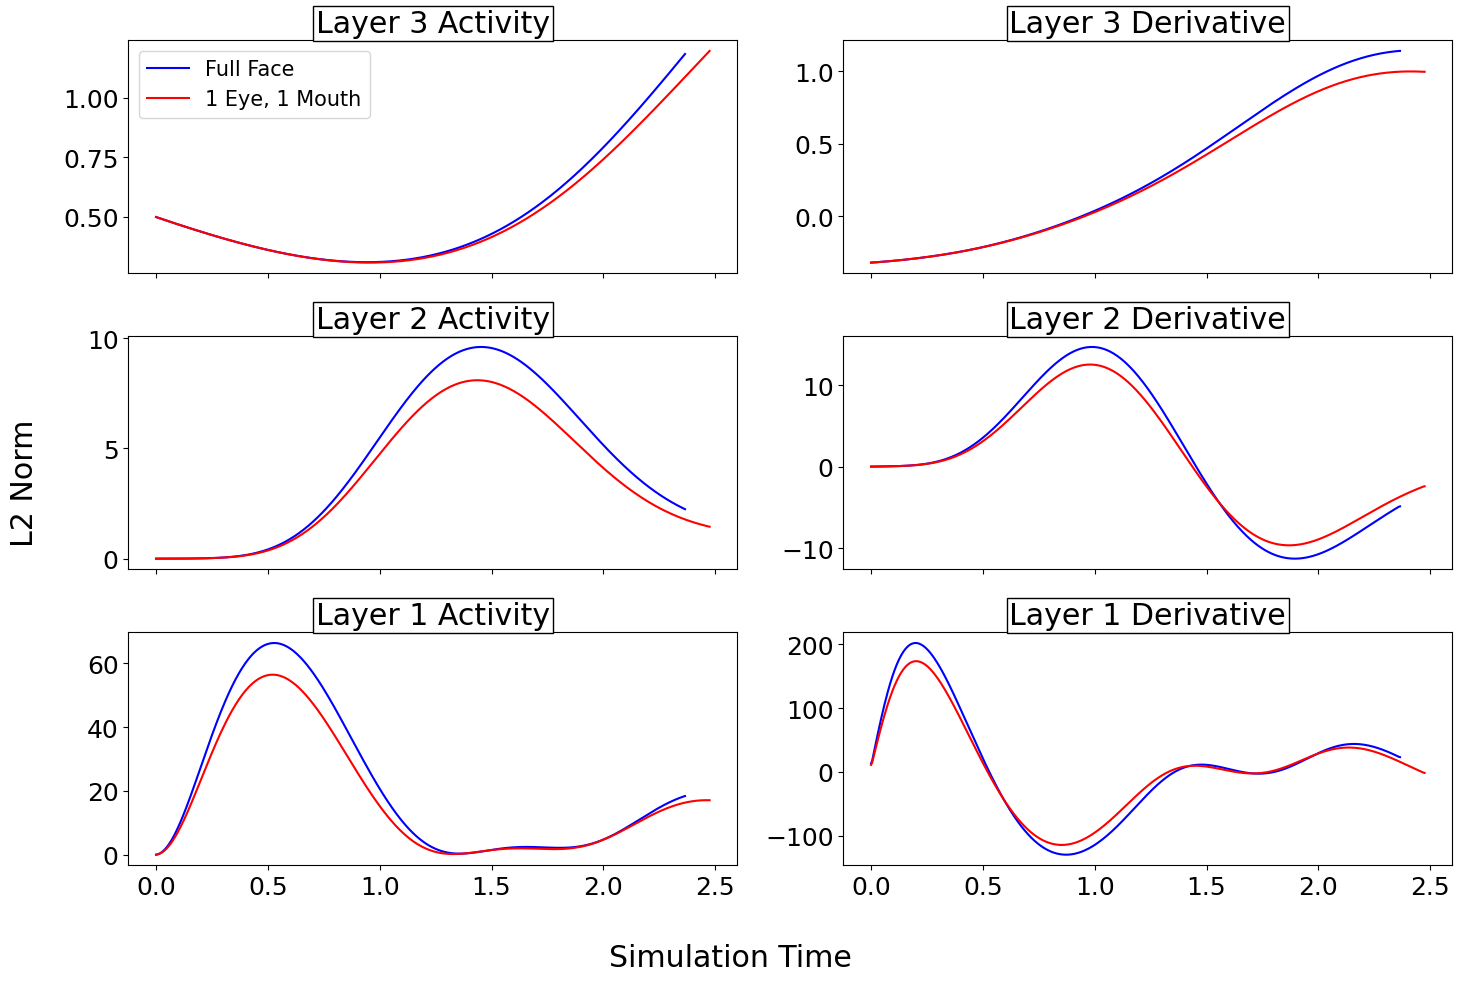

In [12]:
fig, axes = plt.subplots(len(phase_spaces), 2, sharex=True, figsize=(15, 10))

for idx in range(len(phase_spaces)):
    reverse_idx = len(phase_spaces) - idx #index for plotting to be consistent with
    
    rows = phase_spaces[idx].shape[0]
    rows2 = phase_spaces2[idx].shape[0]
    
    axes[idx, 0].plot([args.test_lr*i for i in range(rows)], phase_spaces[idx], label="Full Face", color="blue")
    axes[idx, 0].plot([args.test_lr*i for i in range(rows2)], phase_spaces2[idx], label="1 Eye, 1 Mouth", color="red")
    axes[idx, 0].set_title(f"Layer {reverse_idx} Activity", bbox=dict(facecolor='white', edgecolor='black', pad=2))

for idx in range(len(phase_spaces)):
    reverse_idx = len(phase_spaces) - idx #index for plotting to be consistent with
    #derivatives
    if phase_spaces[idx].size == 1 or phase_spaces2[idx].size == 1:
        axes[idx, 1].set_title(f"Layer {reverse_idx} Derivative", bbox=dict(facecolor='white', edgecolor='black', pad=2))
        continue
    else:
        axes[idx, 1].set_title(f"Layer {reverse_idx} Derivative", bbox=dict(facecolor='white', edgecolor='black', pad=2))
        der = derivative(phase_spaces[idx])
        der2 = derivative(phase_spaces2[idx])

    rows = der.shape[0]
    rows2 = der2.shape[0]
    
    axes[idx, 1].plot([args.test_lr*i for i in range(rows)], der, label="Full Face", color="blue")
    axes[idx, 1].plot([args.test_lr*i for i in range(rows2)], der2, label="1 Eye, 1 Mouth", color="red")

axes[0, 0].legend(fontsize='small')
#axes[0].set_title(f"Layer {len(phase_spaces)} (Output Layer)", bbox=dict(facecolor='white', edgecolor='black', pad=2))
fig.supxlabel("Simulation Time")
fig.supylabel('L2 Norm')
fig.tight_layout()
plt.savefig("layers_activity.svg", format='svg')
plt.show()

In [13]:
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl_single_sample))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)
    conv_times = []
    label_preds, times, phase_space = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                     tol=1e-4, norm=None, 
                                                     mu_dt=args.test_lr, error_dt=args.test_lr, norm_errors=False, activities_index=0)
    for idx in range(len(times)):
        if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
            conv_times.append(times[idx])
    print(conv_times)

[2.325]


In [14]:
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl_single_sample2))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)
    conv_times = []
    label_preds, times, phase_space2 = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                     tol=1e-4, norm=None, 
                                                     mu_dt=args.test_lr, error_dt=args.test_lr, norm_errors=False, activities_index=0)
    for idx in range(len(times)):
        if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
            conv_times.append(times[idx])
    print(conv_times)

[2.49]


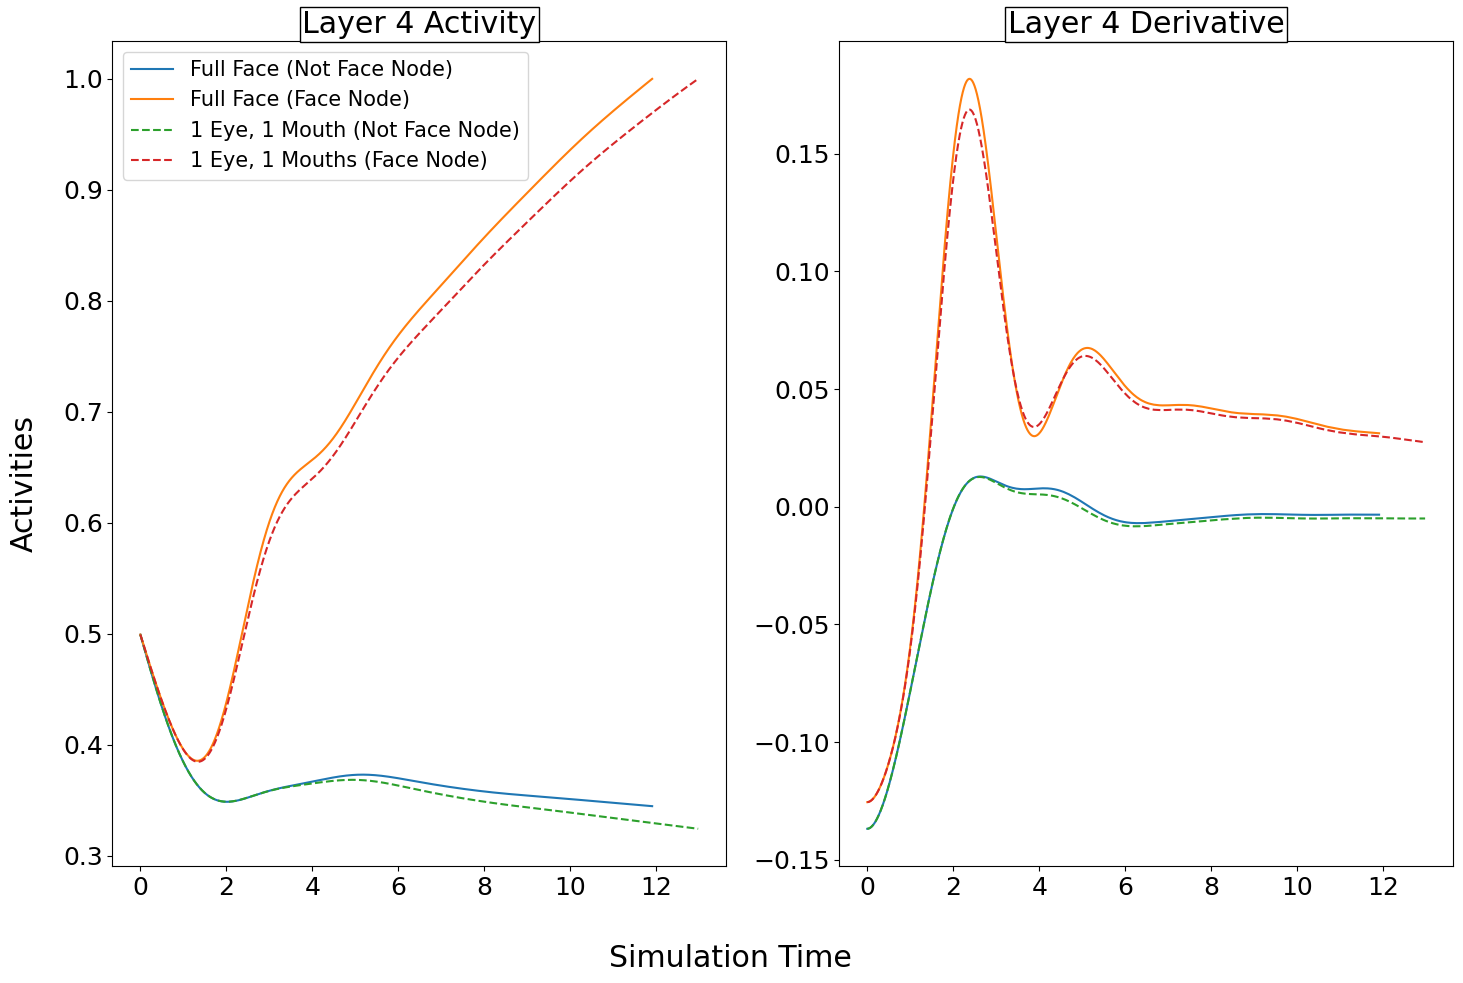

In [30]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 10))

rows = phase_space.shape[0]
rows2 = phase_space2.shape[0]

#[args.test_lr*i for i in range(rows)], 
axes[0].plot([args.test_lr*i for i in range(rows)],phase_space)#, label="Full Face")
axes[0].plot([args.test_lr*i for i in range(rows2)],phase_space2, ls="--"),# label="1 Eye, 1 Mouth")
axes[0].set_title(f"Layer {4} Activity", bbox=dict(facecolor='white', edgecolor='black', pad=2))

der = derivative(phase_space)
der2 = derivative(phase_space2)
axes[1].plot([args.test_lr*i for i in range(rows)],der)#, label="Full Face")
axes[1].plot([args.test_lr*i for i in range(rows2)],der2, ls="--")#, label="1 Eye, 1 Mouth")
axes[1].set_title(f"Layer {4} Derivative", bbox=dict(facecolor='white', edgecolor='black', pad=2))

axes[0].legend(["Full Face (Not Face Node)", "Full Face (Face Node)", "1 Eye, 1 Mouth (Not Face Node)", "1 Eye, 1 Mouths (Face Node)"], fontsize='small')
#axes[0].set_title(f"Layer {len(phase_spaces)} (Output Layer)", bbox=dict(facecolor='white', edgecolor='black', pad=2))
fig.supxlabel("Simulation Time")
fig.supylabel('Activities')
fig.tight_layout()
plt.show()

In [56]:
phase_space.shape

(1977, 2)

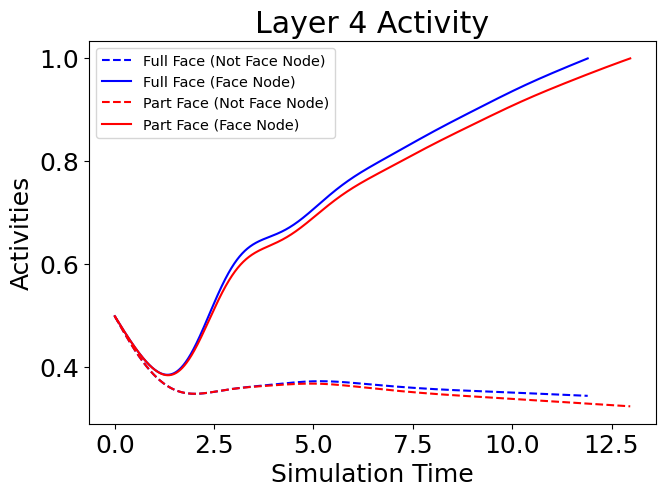

In [33]:
fig = plt.figure(figsize=(7, 5))

rows = phase_space.shape[0]
rows2 = phase_space2.shape[0]

#[args.test_lr*i for i in range(rows)], 
plt.plot([args.test_lr*i for i in range(rows)],phase_space[:,0], label="Full Face (Not Face Node)", color="b", ls="--")#, label="Full Face")
plt.plot([args.test_lr*i for i in range(rows)],phase_space[:,1], label="Full Face (Face Node)", color="b")
plt.plot([args.test_lr*i for i in range(rows2)],phase_space2[:,0], label="Part Face (Not Face Node)", color="r", ls="--"),# label="1 Eye, 1 Mouth")
plt.plot([args.test_lr*i for i in range(rows2)],phase_space2[:,1], label="Part Face (Face Node)", color="r"),# label="1 Eye, 1 Mouth")

#axes[0].set_title(f"Layer {len(phase_spaces)} (Output Layer)", bbox=dict(facecolor='white', edgecolor='black', pad=2))
plt.xlabel("Simulation Time")
plt.ylabel('Activities')
plt.tight_layout()
plt.title(f"Layer {4} Activity")
plt.legend(fontsize='xx-small')
plt.savefig("output_neurons.svg", format='svg')
plt.show()

# ImageNet

In [18]:
val_loader = get_imagenet_validation_dataloader(classes=classes, num_images=10000, batch_size=1)

In [19]:
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl_single_sample))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)
    conv_times = []
    label_preds, times, phase_space = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                     tol=1e-4, norm=None, 
                                                     mu_dt=args.test_lr, error_dt=args.test_lr, norm_errors=False, activities_index=0)
    for idx in range(len(times)):
        if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
            conv_times.append(times[idx])
    print(conv_times)

[11.405]


In [26]:
with torch.no_grad():
    img_batch, label_batch = next(iter(val_loader))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)
    conv_times = []
    label_preds, times, phase_space2 = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                     tol=1e-4, norm=None, 
                                                     mu_dt=args.test_lr, error_dt=args.test_lr, norm_errors=False, activities_index=0)
    for idx in range(len(times)):
        if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
            conv_times.append(times[idx])
    print(conv_times)

[]


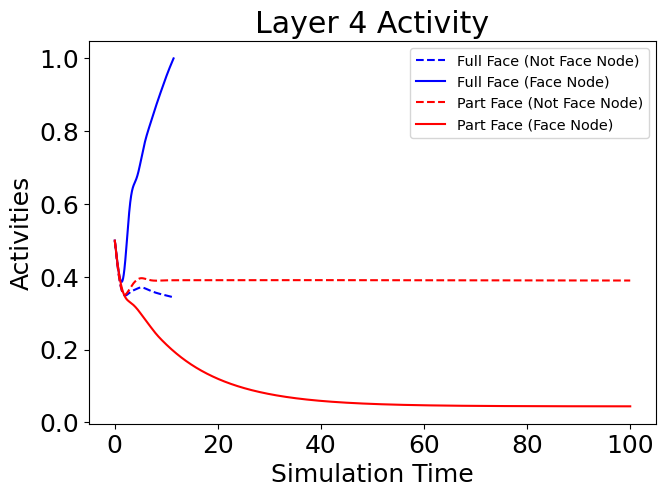

In [27]:
fig = plt.figure(figsize=(7, 5))

rows = phase_space.shape[0]
rows2 = phase_space2.shape[0]

#[args.test_lr*i for i in range(rows)], 
plt.plot([args.test_lr*i for i in range(rows)],phase_space[:,0], label="Full Face (Not Face Node)", color="b", ls="--")#, label="Full Face")
plt.plot([args.test_lr*i for i in range(rows)],phase_space[:,1], label="Full Face (Face Node)", color="b")
plt.plot([args.test_lr*i for i in range(rows2)],phase_space2[:,0], label="Part Face (Not Face Node)", color="r", ls="--"),# label="1 Eye, 1 Mouth")
plt.plot([args.test_lr*i for i in range(rows2)],phase_space2[:,1], label="Part Face (Face Node)", color="r"),# label="1 Eye, 1 Mouth")

#axes[0].set_title(f"Layer {len(phase_spaces)} (Output Layer)", bbox=dict(facecolor='white', edgecolor='black', pad=2))
plt.xlabel("Simulation Time")
plt.ylabel('Activities')
plt.tight_layout()
plt.title(f"Layer {4} Activity")
plt.legend(fontsize='xx-small')
plt.show()

# All Combinations

In [11]:
dl = get_single_image_dataloader(sex="M", id="01", reflection=False, face_path=face_path, 
                                 size=(68, 100), radius=(2, 3),
                                 num_translations=0, num_rotations=0, min_shift=0, max_shift=0, min_angle=0, max_angle=0,
                                 batch_size=8, shuffle=False, channels=True,
                                 output_vec_dic=None)

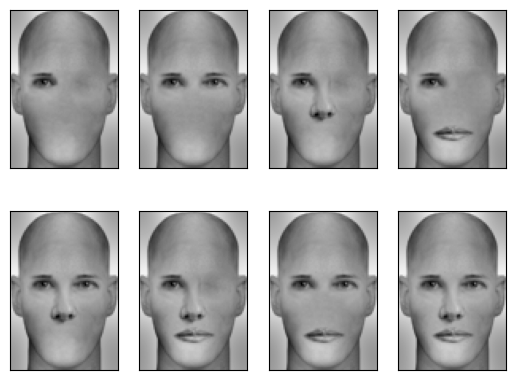

In [12]:
img_batch, label_batch = next(iter(dl))
fig, axs = plt.subplots(2, 4)
i = 0
for ax in axs.flat:
    ax.imshow(img_batch[i].squeeze(0), cmap="gray")
    #ax.set_title(labels[i].item())
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    i += 1

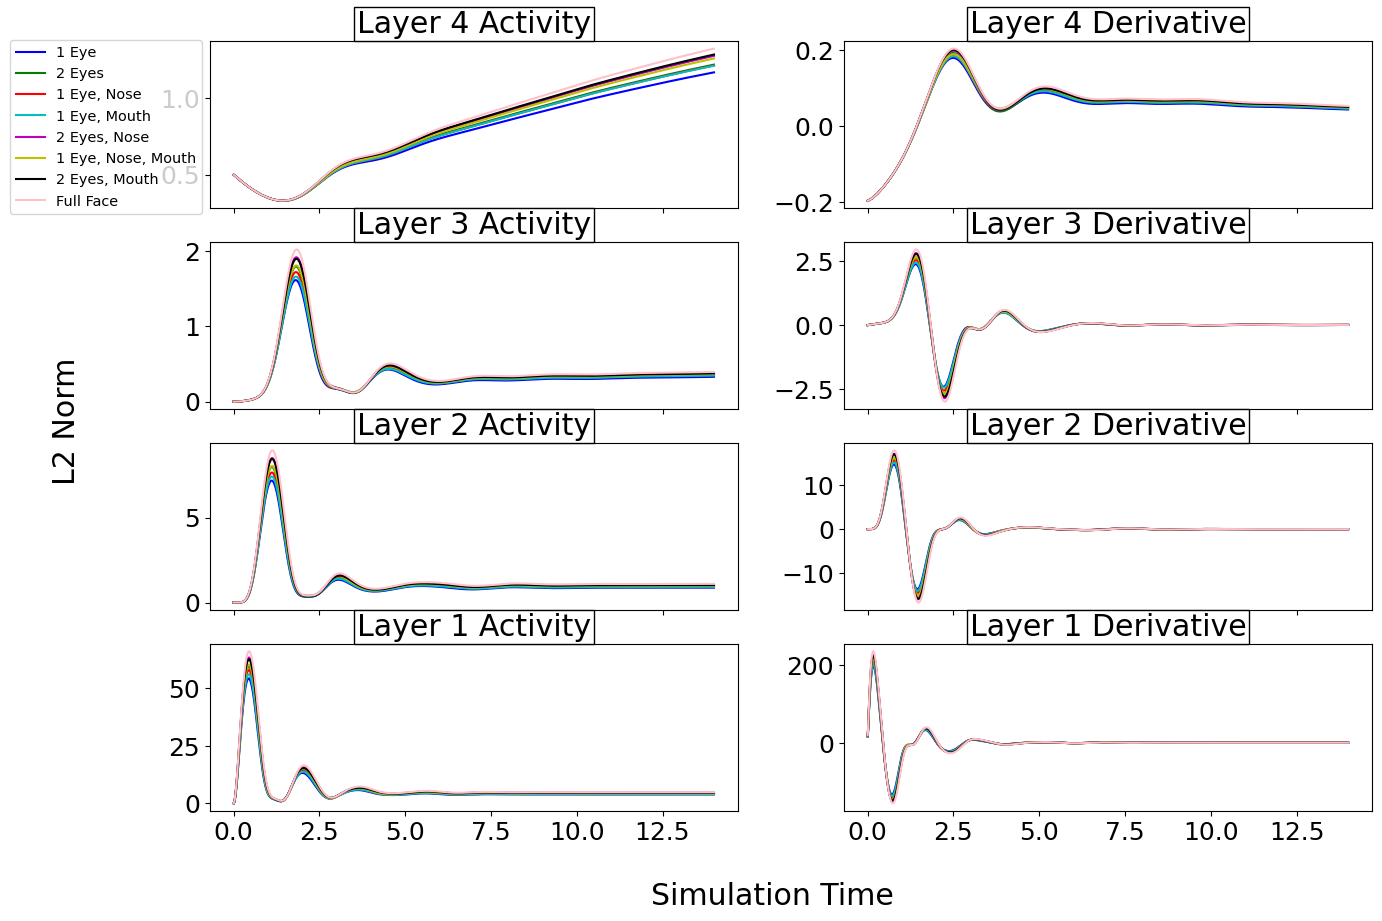

In [13]:
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(15, 10))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'pink']
for layer_idx in range(4):
    reverse_idx = 4 - layer_idx #index for plotting to be consistent with
    
    with torch.no_grad():
        img_batch, label_batch = next(iter(dl))
        
        label_batch = label_batch.long()
        img_batch = img_batch.double()
        
        img_batch = utils.to_vector(img_batch).to(device)
        label_batch = utils.one_hot(label_batch, n_classes=2).to(device)
        conv_times = []
        label_preds, times, phase_spaces = model.test_batch_supervised_phase_space(img_batch, label_batch, 20000, fixed_preds=False, 
                                                         tol=1e-4, norm="Activity", 
                                                         mu_dt=args.test_lr, error_dt=None, norm_errors=False, activities_index=layer_idx)
    for index, feature_num in enumerate(list(range(2, 8))+[17, 8]):
        phase_space = phase_spaces[:,index]
        rows = phase_space.shape[0]
        
        axes[layer_idx, 0].plot([args.test_lr*i for i in range(rows)], phase_space, label=face_features_flip_dict[feature_num], color=colors[index])
        axes[layer_idx, 0].set_title(f"Layer {reverse_idx} Activity", bbox=dict(facecolor='white', edgecolor='black', pad=2))

        if phase_space.size == 1:
            axes[layer_idx, 1].set_title(f"Layer {reverse_idx} Derivative", bbox=dict(facecolor='white', edgecolor='black', pad=2))
            continue
        else:
            axes[layer_idx, 1].set_title(f"Layer {reverse_idx} Derivative", bbox=dict(facecolor='white', edgecolor='black', pad=2))
            der = derivative(phase_space)
        axes[layer_idx, 1].plot([args.test_lr*i for i in range(rows)], der, label="Full Face", color=colors[index])

axes[0, 0].legend(bbox_to_anchor=(0, 1.05), fontsize='xx-small')
#axes[0].set_title(f"Layer {len(phase_spaces)} (Output Layer)", bbox=dict(facecolor='white', edgecolor='black', pad=2))
fig.supxlabel("Simulation Time")
fig.supylabel('L2 Norm')
#fig.tight_layout()
plt.savefig("layers_activity.svg", format='svg')
plt.show()
"""       
for idx in range(len(phase_spaces)):
    reverse_idx = len(phase_spaces) - idx #index for plotting to be consistent with
    
    rows = phase_spaces[idx].shape[0]
    rows2 = phase_spaces2[idx].shape[0]
    
    axes[idx, 0].plot([args.test_lr*i for i in range(rows)], phase_spaces[idx], label="Full Face", color="blue")
    axes[idx, 0].plot([args.test_lr*i for i in range(rows2)], phase_spaces2[idx], label="1 Eye, 1 Mouth", color="red")
    axes[idx, 0].set_title(f"Layer {reverse_idx} Activity", bbox=dict(facecolor='white', edgecolor='black', pad=2))

for idx in range(len(phase_spaces)):
    reverse_idx = len(phase_spaces) - idx #index for plotting to be consistent with
    #derivatives
    if phase_spaces[idx].size == 1 or phase_spaces2[idx].size == 1:
        axes[idx, 1].set_title(f"Layer {reverse_idx} Derivative", bbox=dict(facecolor='white', edgecolor='black', pad=2))
        continue
    else:
        axes[idx, 1].set_title(f"Layer {reverse_idx} Derivative", bbox=dict(facecolor='white', edgecolor='black', pad=2))
        der = derivative(phase_spaces[idx])
        der2 = derivative(phase_spaces2[idx])

    rows = der.shape[0]
    rows2 = der2.shape[0]
    
    axes[idx, 1].plot([args.test_lr*i for i in range(rows)], der, label="Full Face", color="blue")
    axes[idx, 1].plot([args.test_lr*i for i in range(rows2)], der2, label="1 Eye, 1 Mouth", color="red")

axes[0, 0].legend(fontsize='small')
#axes[0].set_title(f"Layer {len(phase_spaces)} (Output Layer)", bbox=dict(facecolor='white', edgecolor='black', pad=2))
fig.supxlabel("Simulation Time")
fig.supylabel('L2 Norm')
fig.tight_layout()
plt.savefig("layers_activity.svg", format='svg')
plt.show()
"""
temp =0

In [19]:
dl = get_single_image_dataloader(sex="M", id="01", reflection=False, face_path=face_path, 
                                 size=(68, 100), radius=(2, 3),
                                 num_translations=0, num_rotations=0, min_shift=0, max_shift=0, min_angle=0, max_angle=0,
                                 batch_size=1, shuffle=False, channels=True,
                                 output_vec_dic=None, outline=True)
face_features_flip_dict[0] = "Outline"

In [23]:
model = networks[np.random.randint(0, len(networks))]

torch.Size([1, 1, 100, 68])


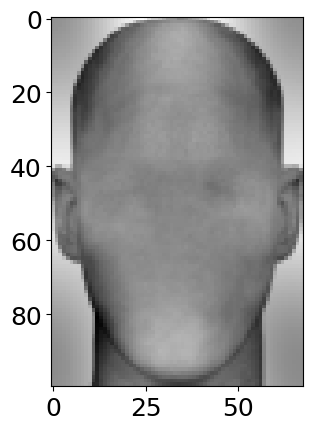

torch.Size([1, 1, 100, 68])


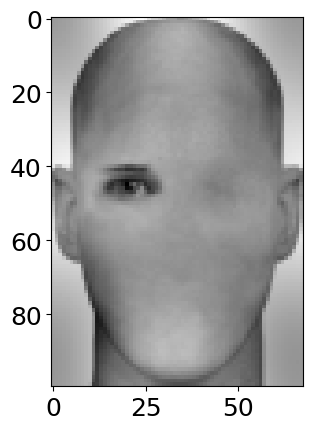

torch.Size([1, 1, 100, 68])


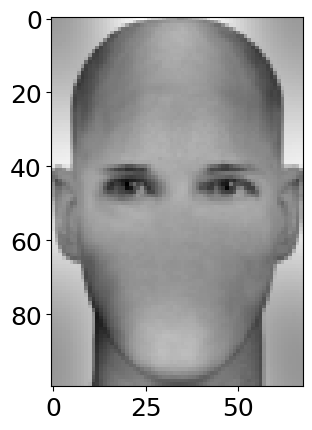

torch.Size([1, 1, 100, 68])


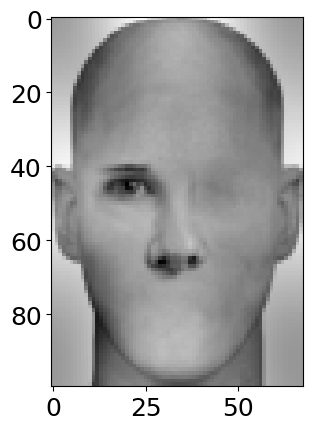

torch.Size([1, 1, 100, 68])


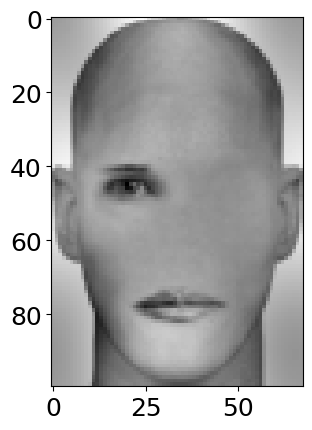

torch.Size([1, 1, 100, 68])


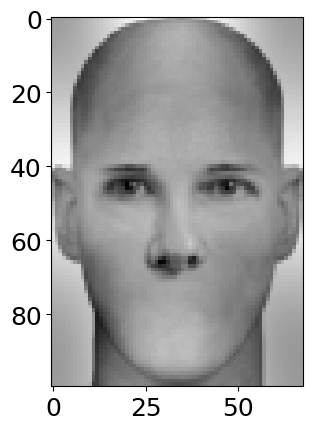

torch.Size([1, 1, 100, 68])


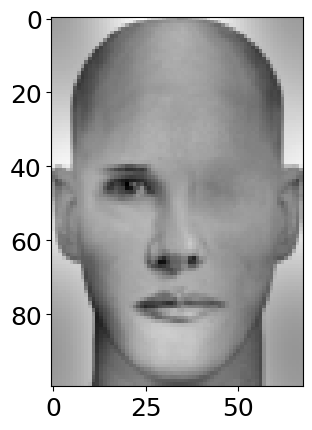

torch.Size([1, 1, 100, 68])


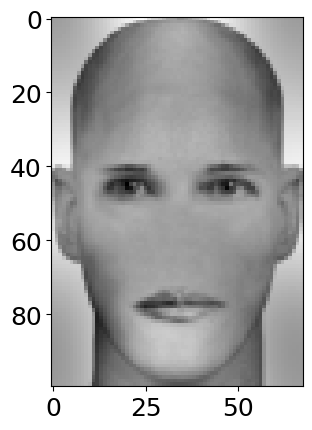

torch.Size([1, 1, 100, 68])


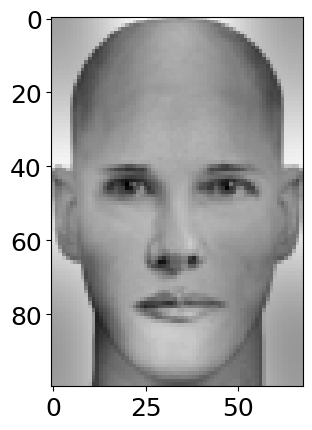

In [10]:
with torch.no_grad():
    for batch_idx, (img_batch, label_batch) in enumerate(dl):
        print(img_batch.shape)
        plt.figure()
        plt.imshow(img_batch[0].squeeze(0), cmap="gray")
        plt.show()

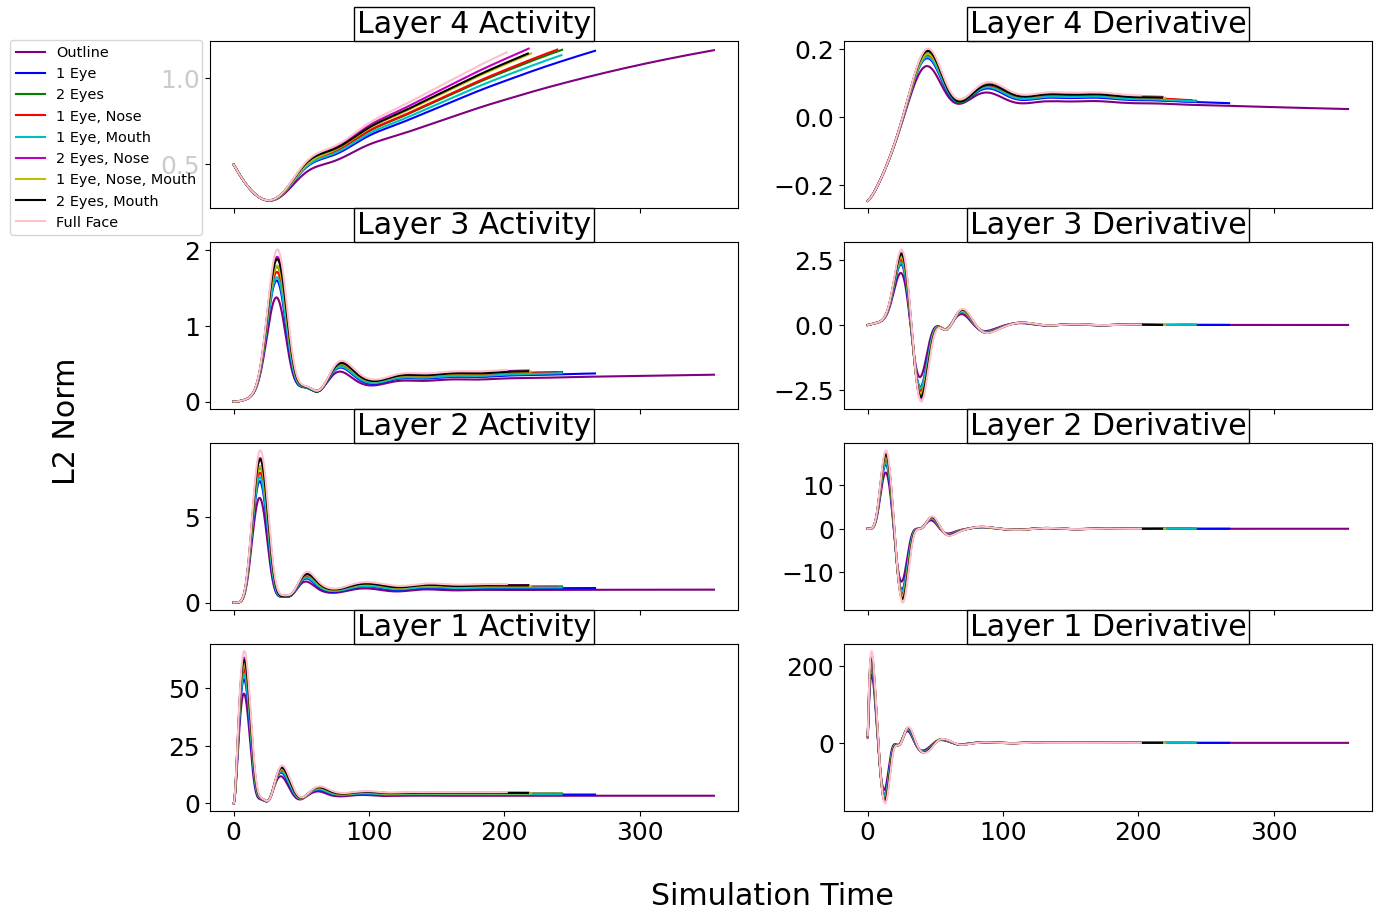

In [25]:
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(15, 10))

colors = ['purple', 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'pink']
feature_nums = [0] + list(range(2, 8))+[17, 8]
for layer_idx in range(4):
    reverse_idx = 4 - layer_idx #index for plotting to be consistent with

    with torch.no_grad():
        for batch_idx, (img_batch, label_batch) in enumerate(dl):
    
            label_batch = label_batch.long()
            img_batch = img_batch.double()
            
            img_batch = utils.to_vector(img_batch).to(device)
            label_batch = utils.one_hot(label_batch, n_classes=2).to(device)
            conv_times = []
            label_preds, times, phase_spaces = model.test_batch_supervised_phase_space(img_batch, label_batch, 20000, fixed_preds=False, 
                                                             tol=1e-4, norm="Activity", 
                                                             mu_dt=args.test_lr, error_dt=None, norm_errors=False, activities_index=layer_idx)
    
            phase_space = phase_spaces[:,0]
            rows = phase_space.shape[0]
            axes[layer_idx, 0].plot([args.test_lr*i*300/17 for i in range(rows)], phase_space, label=face_features_flip_dict[feature_nums[batch_idx]], color=colors[batch_idx])
            axes[layer_idx, 0].set_title(f"Layer {reverse_idx} Activity", bbox=dict(facecolor='white', edgecolor='black', pad=2))
    
            if phase_space.size == 1:
                axes[layer_idx, 1].set_title(f"Layer {reverse_idx} Derivative", bbox=dict(facecolor='white', edgecolor='black', pad=2))
                continue
            else:
                axes[layer_idx, 1].set_title(f"Layer {reverse_idx} Derivative", bbox=dict(facecolor='white', edgecolor='black', pad=2))
                der = derivative(phase_space)
            axes[layer_idx, 1].plot([args.test_lr*i*300/17 for i in range(rows)], der, color=colors[batch_idx])

axes[0, 0].legend(bbox_to_anchor=(0, 1.05), fontsize='xx-small')
#axes[0].set_title(f"Layer {len(phase_spaces)} (Output Layer)", bbox=dict(facecolor='white', edgecolor='black', pad=2))
fig.supxlabel("Simulation Time")
fig.supylabel('L2 Norm')
#fig.tight_layout()
plt.savefig("layers_activity.svg", format='svg')
plt.show()

In [22]:
len(classes)

21

# Combine Layers

## Test Methods

In [8]:
test_dl_single_sample = get_dataloader_features(feature=8, num_translations=0, num_rotations=0, batch_size=1)

In [16]:
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl_single_sample))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)

    label_preds, times, phase_space = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                         tol=1e-4, norm="Activity", 
                                                         mu_dt=args.test_lr, error_dt=args.test_lr, norm_errors=False, activities_index=[2, 3])

In [17]:
phase_space.shape

(2271, 1)

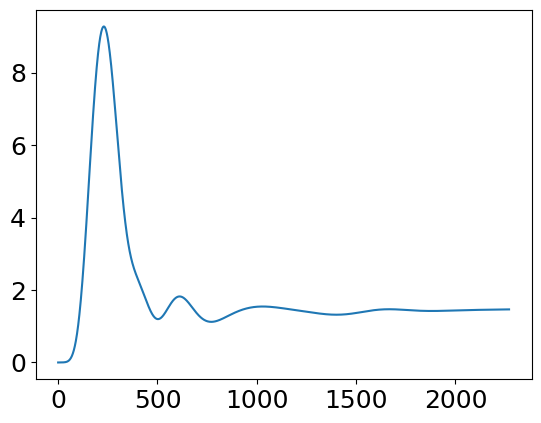

In [18]:
plt.plot(phase_space.squeeze())

## Every Feature Combination

In [19]:
dl = get_single_image_dataloader(sex="M", id="01", reflection=False, face_path=face_path, 
                                 size=(68, 100), radius=(2, 3),
                                 num_translations=0, num_rotations=0, min_shift=0, max_shift=0, min_angle=0, max_angle=0,
                                 batch_size=8, shuffle=False, channels=True,
                                 output_vec_dic=None)

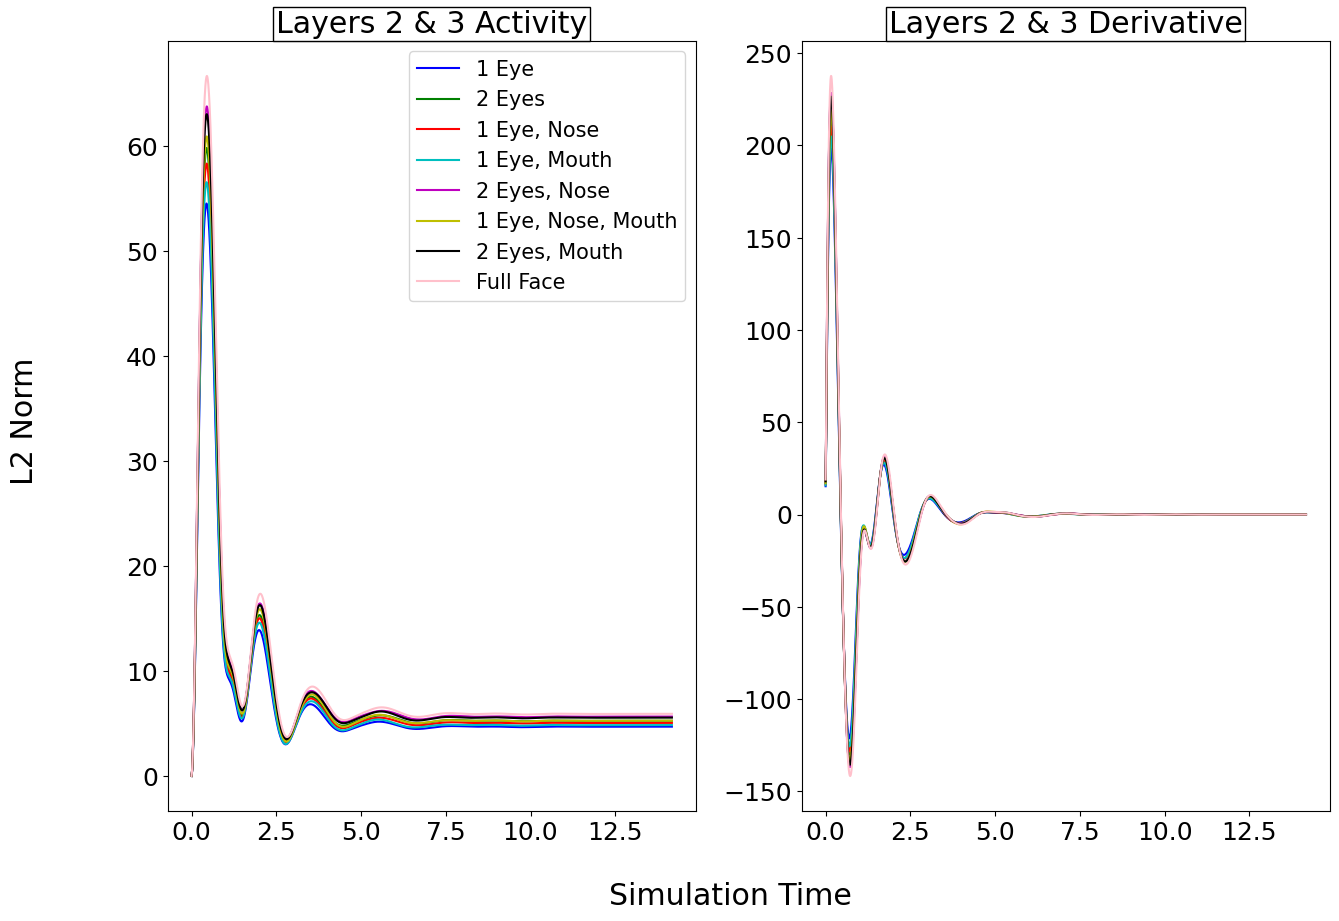

In [23]:
with torch.no_grad():
    img_batch, label_batch = next(iter(dl))
    
    label_batch = label_batch.long()
    img_batch = img_batch.double()
    
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = utils.one_hot(label_batch, n_classes=2).to(device)
    conv_times = []
    label_preds, times, phase_spaces = model.test_batch_supervised_phase_space(img_batch, label_batch, 20000, fixed_preds=False, 
                                                     tol=1e-4, norm="Activity", 
                                                     mu_dt=args.test_lr, error_dt=None, norm_errors=False, activities_index=[2, 3])

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 10))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'pink']

for index, feature_num in enumerate(list(range(2, 8))+[17, 8]):
    phase_space = phase_spaces[:,index]
    rows = phase_space.shape[0]

    axes[0].plot([args.test_lr*i for i in range(rows)], phase_space, label=face_features_flip_dict[feature_num], color=colors[index])
    axes[0].set_title(f"Layers 2 & 3 Activity", bbox=dict(facecolor='white', edgecolor='black', pad=2))

    if phase_space.size == 1:
        axes[1].set_title(f"Layers 2 & 3 Derivative", bbox=dict(facecolor='white', edgecolor='black', pad=2))
        continue
    else:
        axes[1].set_title(f"Layers 2 & 3 Derivative", bbox=dict(facecolor='white', edgecolor='black', pad=2))
        der = derivative(phase_space)
        axes[1].plot([args.test_lr*i for i in range(rows)], der, label="Full Face", color=colors[index])
        
axes[0].legend(fontsize='small')
#axes[0].set_title(f"Layer {len(phase_spaces)} (Output Layer)", bbox=dict(facecolor='white', edgecolor='black', pad=2))
fig.supxlabel("Simulation Time")
fig.supylabel('L2 Norm')
#fig.tight_layout()
plt.savefig("combined_layers_activity.svg", format='svg')
plt.show()